# **Auto-Encoder**

Implementation of an **auto-encoder** using a deep MLP. I use 6 layers for the 
encoder and 6 for the decoder as well. The goal is to learn to reconstruct hand written 
digits from the MNIST dataset. 

In [577]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA is {'' if torch.cuda.is_available() else 'not '}available")

CUDA is not available


## **Load MNIST dataset**

In [578]:
train_dataset = MNIST(
    root="./data/mnist/train",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_dataset = MNIST(
    root="./data/mnist/test",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [579]:
print(train_dataset.data.shape)
print(train_dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


Visualize arbitrary samples of the dataset

In [580]:
def display_digits(dataset, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 5))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.squeeze().numpy()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

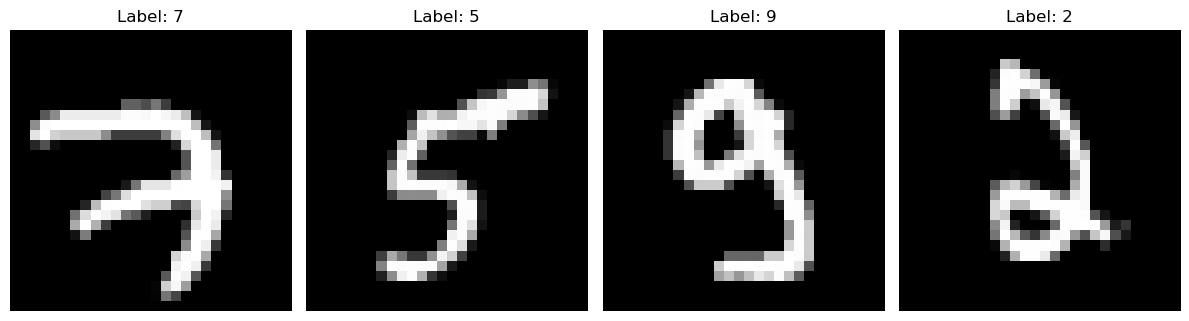

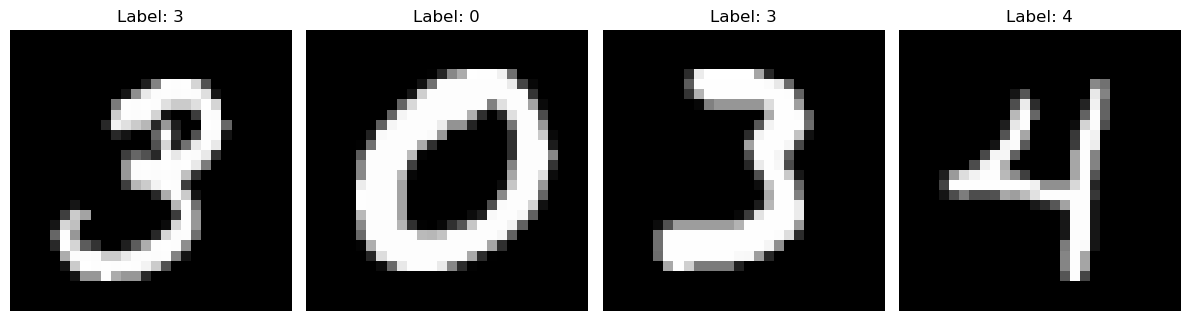

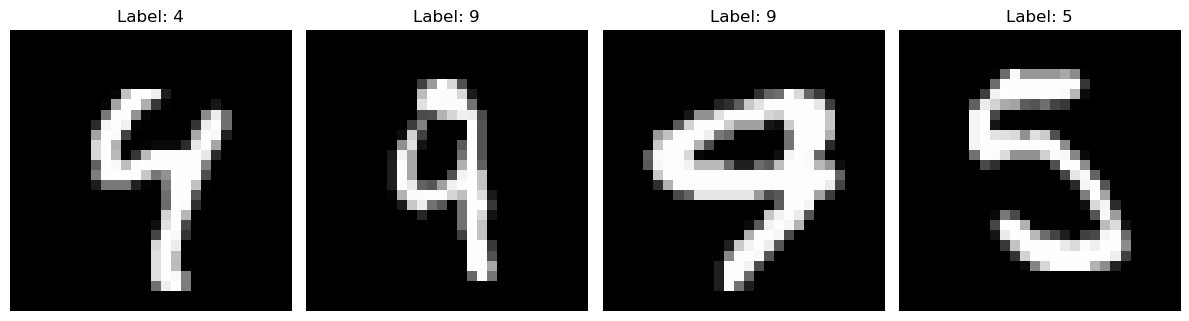

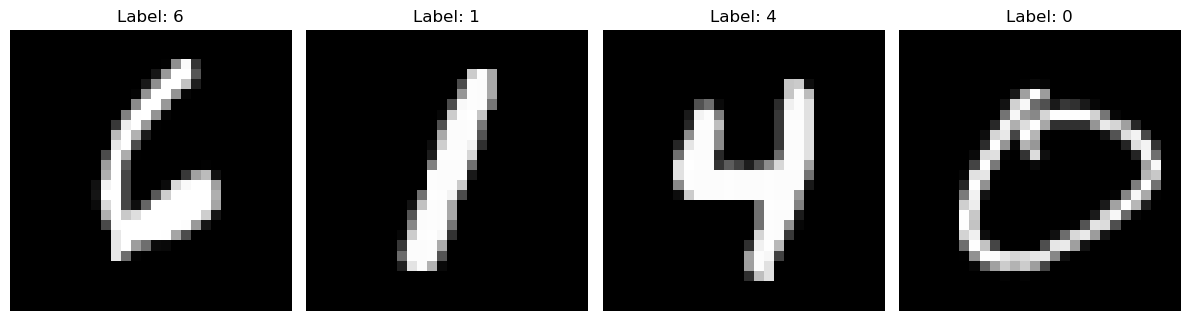

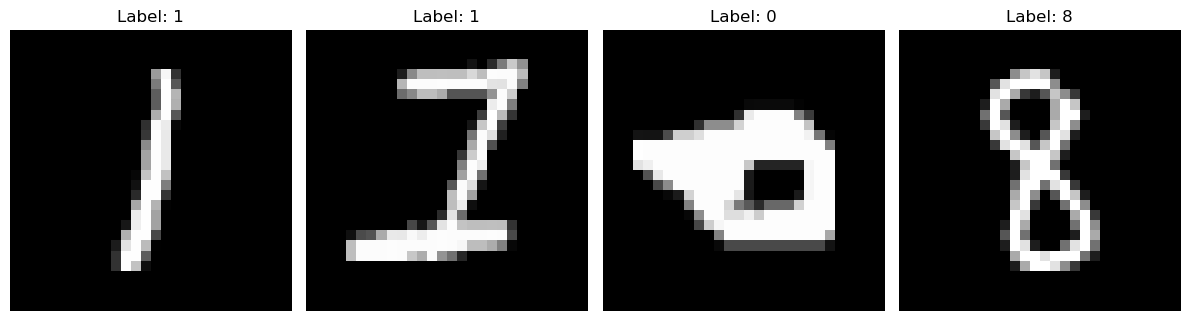

In [581]:
indices = np.array([5000, 8900, 23100, 49993])

for offset in range(5):
    display_digits(train_dataset, indices+offset)

## **Build the Auto-Encoder** 

In [582]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstructed = self.decoder(latent_code)
        return reconstructed

Function to add **Gaussian noise** to the image.

Instead of using the original images to train the autoencoder, we **add Gaussian noise** before using them for training. Again, we evaluate the network's performance against the original images. This technique is employed to **encourage the network to better learn patterns** of the dataset and be able to **reconstruct** it accurately, even when noise is added to the input.

In [583]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Parameter initialization

In [620]:
input_size = 28 * 28
batch = 128
learning_rate = 0.001
num_epochs = 50

In [621]:
autoencoder = AutoEncoder(input_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer=optimizer, gamma=0.8, step_size=20, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [622]:
dataloader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.65)
])

In [623]:
for epoch in range(num_epochs):
    total_loss = 0.0
    
    for X_original, y in dataloader:
        X_original = X_original.view(X_original.size(0), -1)
        X_noisy = transform(X_original.numpy()).view(X_original.size(0), -1) 

        reconstructed = autoencoder(X_noisy)
        loss = loss_function(reconstructed, X_original)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss

    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss}")

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/50, Loss: 31.221363067626953
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2/50, Loss: 23.56488609313965
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3/50, Loss: 21.562822341918945
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 4/50, Loss: 19.436277389526367
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 5/50, Loss: 17.56389808654785
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 6/50, Loss: 16.193403244018555
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7/50, Loss: 15.540705680847168
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8/50, Loss: 15.106579780578613
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9/50, Loss: 14.771053314208984
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10/50, Loss: 14.509664535522461
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11/50, Loss: 14.238096237182617
Adjusting learning rate of group 0 to 1.000

In [624]:
X = train_dataset.data.view(train_dataset.data.size(0), -1)
X_noisy = transform(X.numpy()).view(X.size(0), -1) 

In [647]:
indices = [17001, 500, 3000, 5000, 49993, 10, 39, 28, 0, 40000, 1, 2, 9]
data_for_visualization = []

for index in indices:
    original, label = X[index].view(28, 28), train_dataset.targets[index]
    noisy = X_noisy[index].view(28, 28)
    reconstructed = autoencoder(X_noisy[index]).view(28, 28)
    
    data_for_visualization.append(
        {
            "original": original,
            "noisy": noisy,
            "reconstructed": reconstructed,
            "label": label
        }
    )

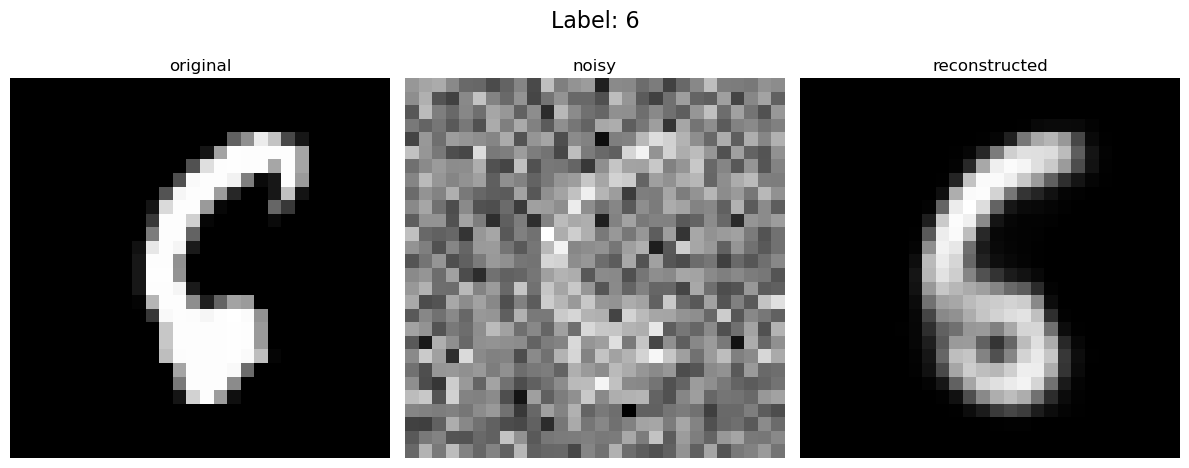

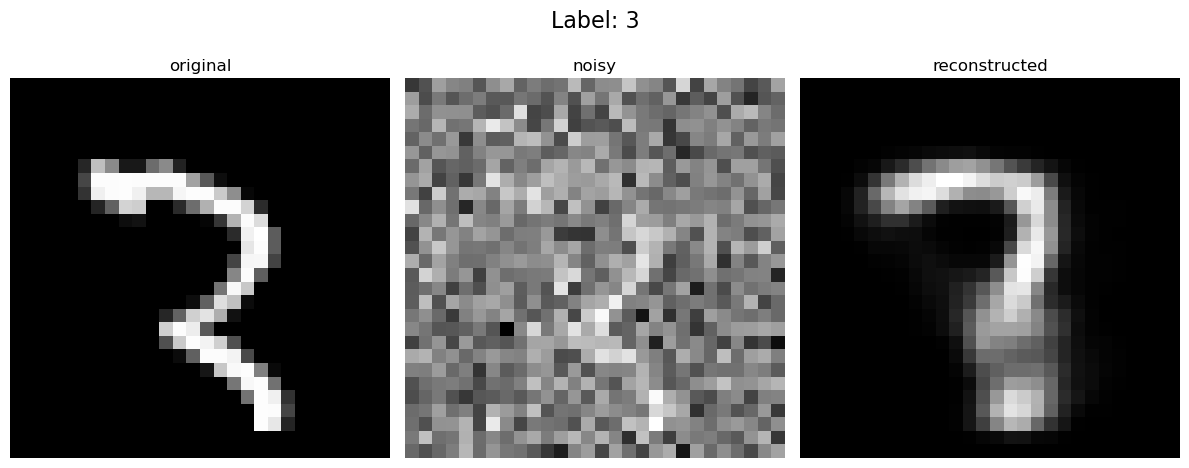

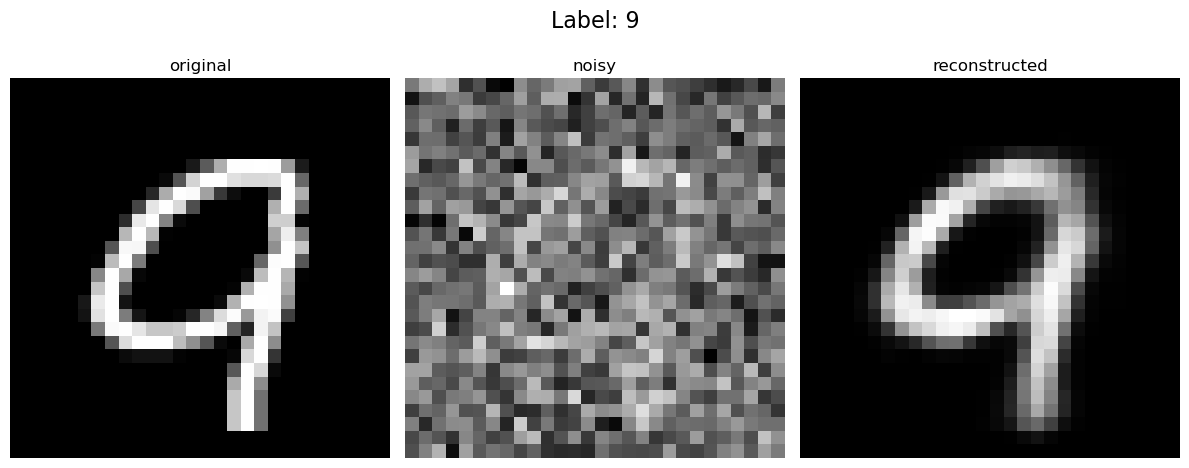

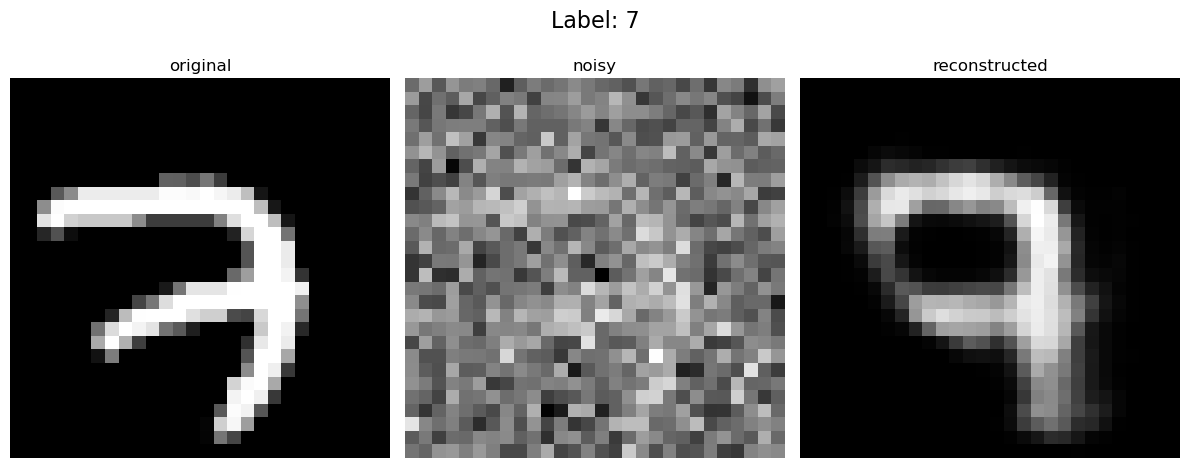

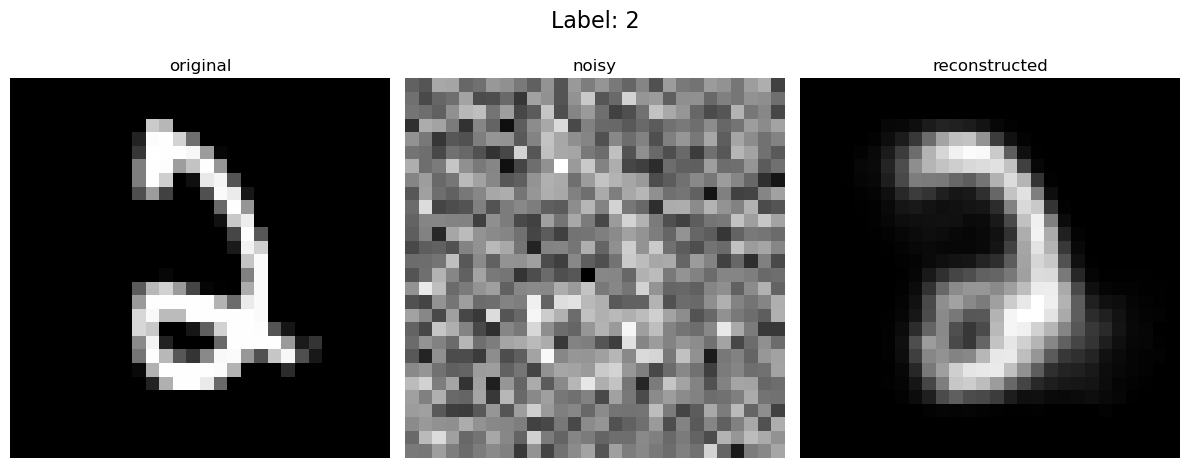

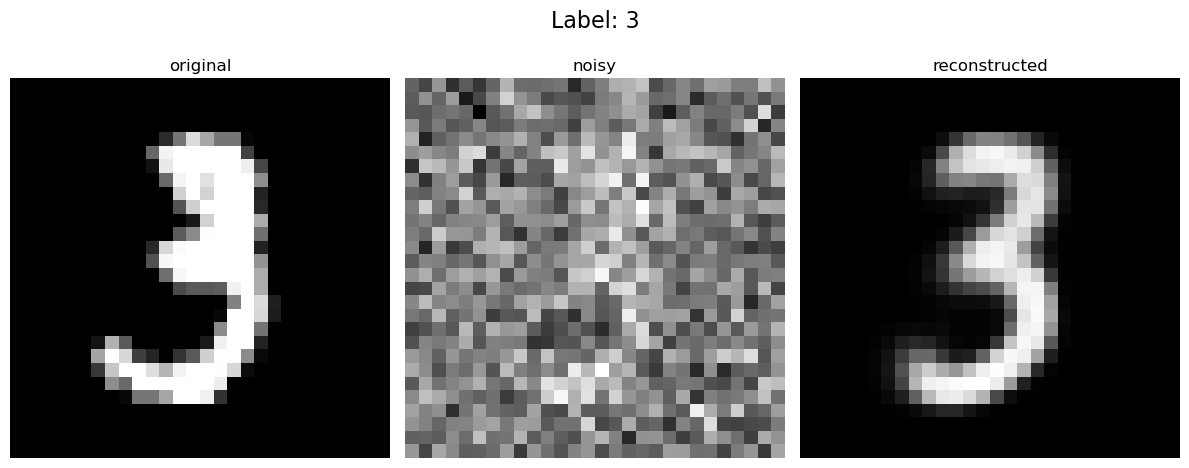

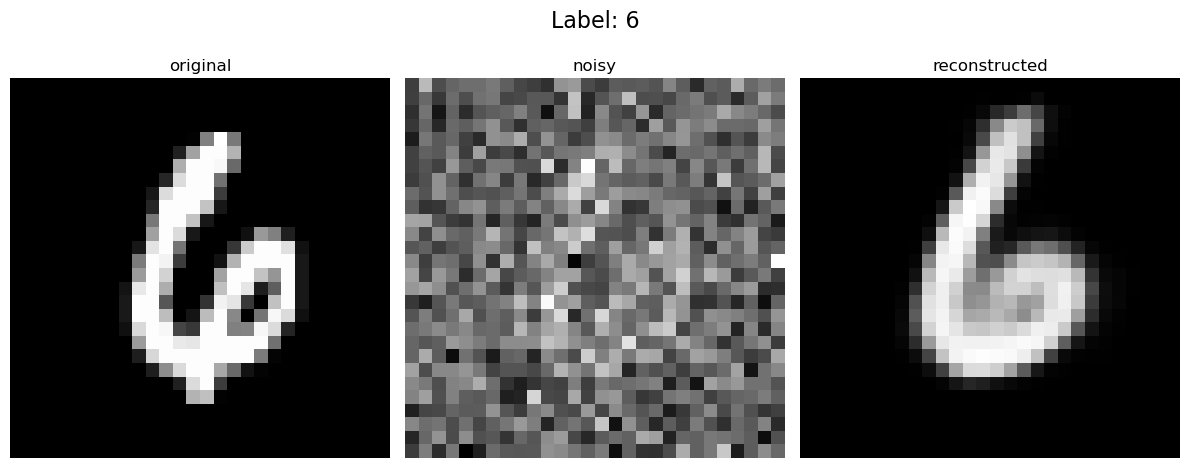

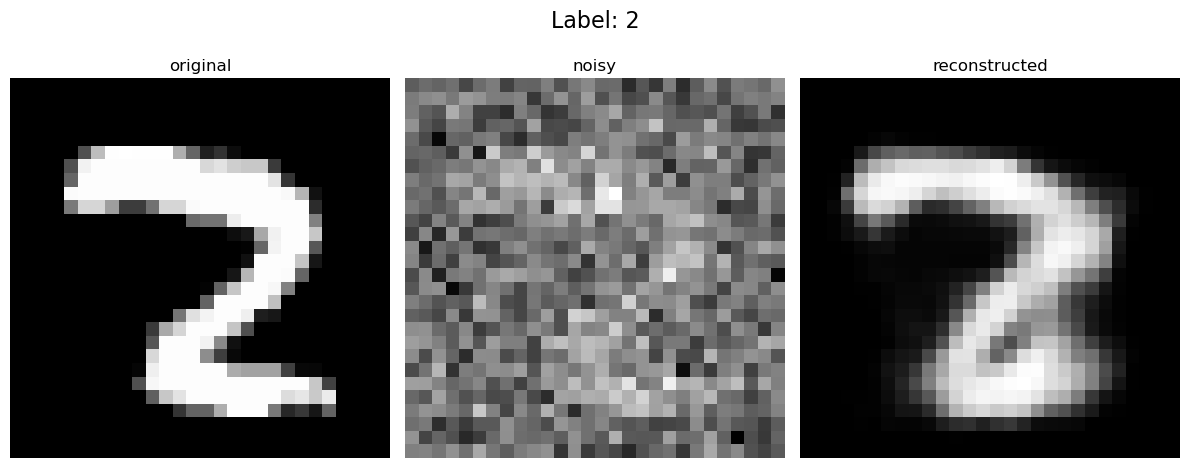

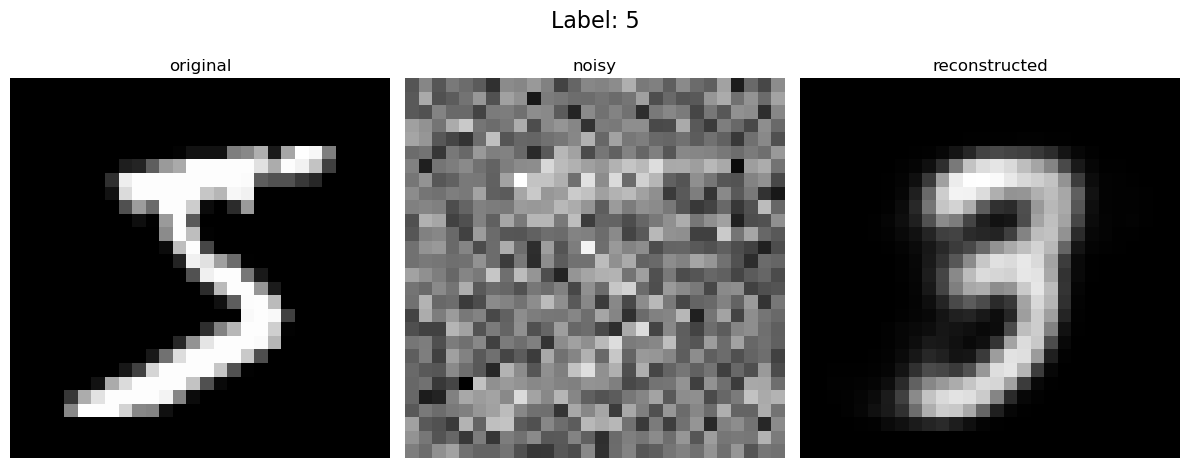

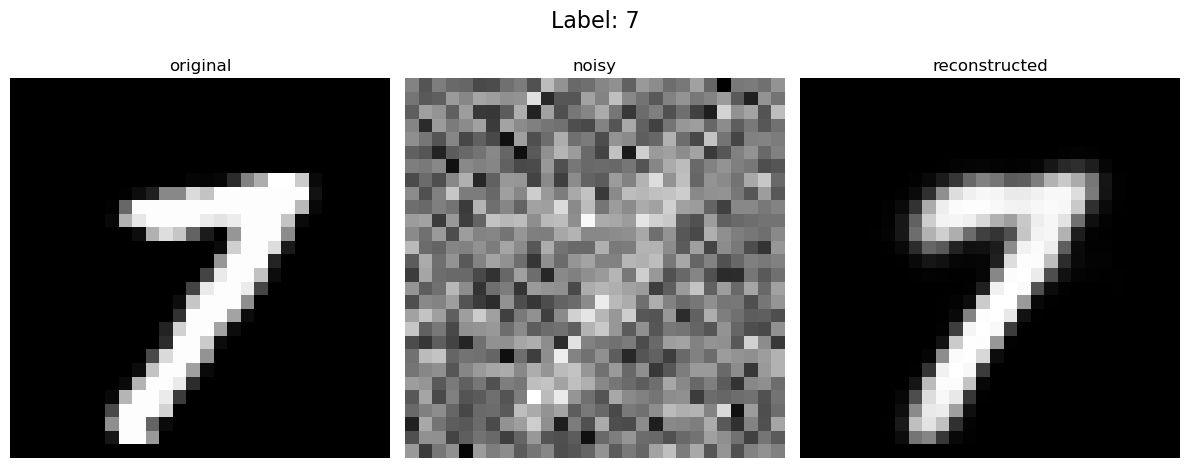

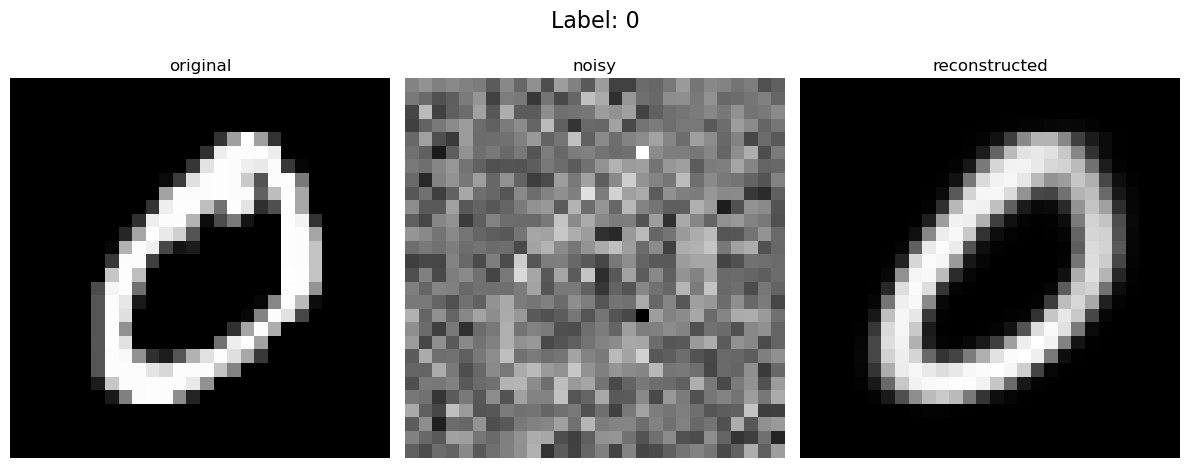

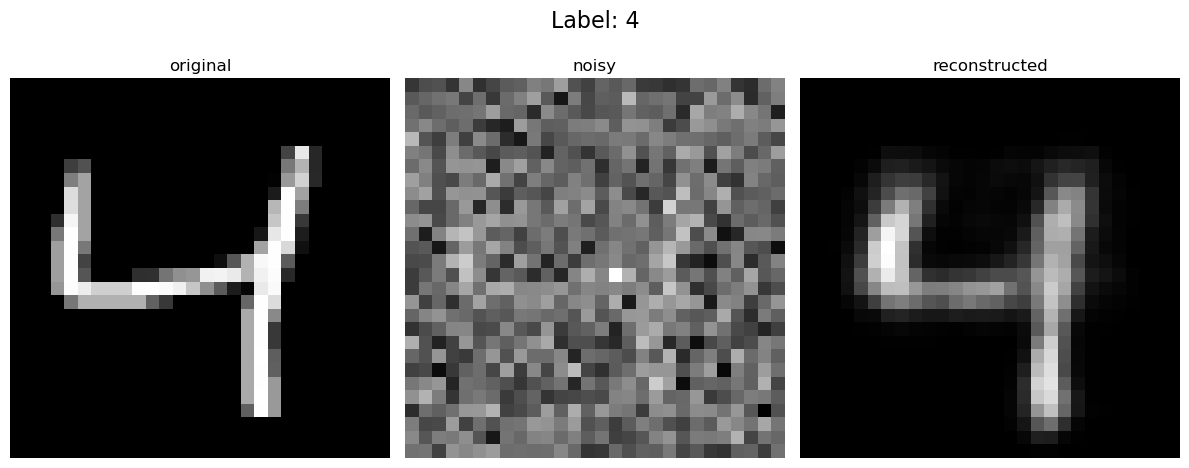

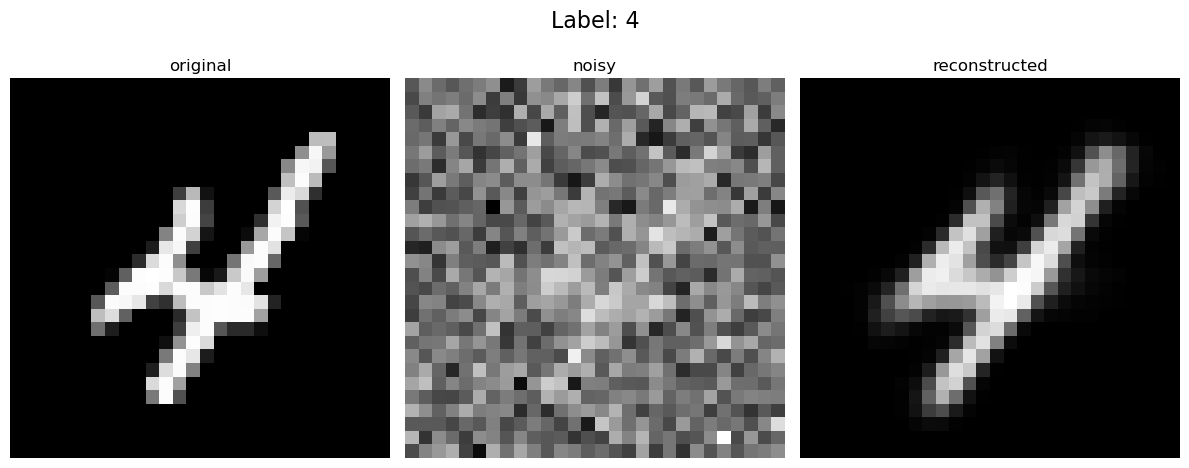

In [648]:
num_images = len(indices)
images_per_row = 3

with torch.inference_mode():
    for count, index in enumerate(indices):
        label = data_for_visualization[count]["label"]
        fig, axes = plt.subplots(1, images_per_row, figsize=(12, 5))
        fig.suptitle(f'Label: {label}', fontsize=16)
        
        for i, version in enumerate(["original", "noisy", "reconstructed"]):
            image = data_for_visualization[count][version]
            image = image.squeeze().numpy()
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"{version}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

## **Deeper Discussion**

The goal of the encoder is to understand the hidden patterns and extract the most meaningful features from the data. The latent code is basically a projection of the input data, to a latent space of lower dimensionality, where the most substantial features and patterns have been learned. The premise is that, using only the latent code, we are able to accurately reconstruct our initial dataset. 

In the above implementation, we add noise to the dataset to guarantee that the network doesn't learn a function like **input * 1 = input**. Indeed, we observe that the network does a pretty good job at understanding the underlying data, even if the latter is significantly distorted.

Another premise is that, similar data should produce similar latent code or better, similar data are close to each other inside the latent space. Let's try to verify that using the **Euclidean Distance** metric for calculating distance.

In [640]:
def distance(a, b):
    return torch.sqrt(((a - b)**2).sum()).item()

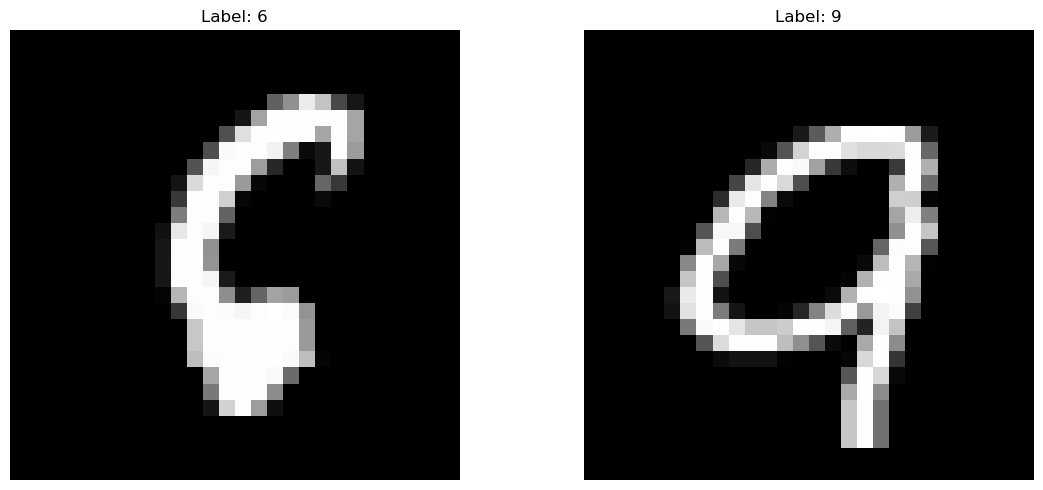

In [649]:
i1 = 17001
i2 = 3000

display_digits(train_dataset, [i1, i2])

In [691]:
latent1 = autoencoder.encoder(X_noisy[i1])
latent2 = autoencoder.encoder(X_noisy[i2])

distance(latent1, latent2)

12.045948028564453

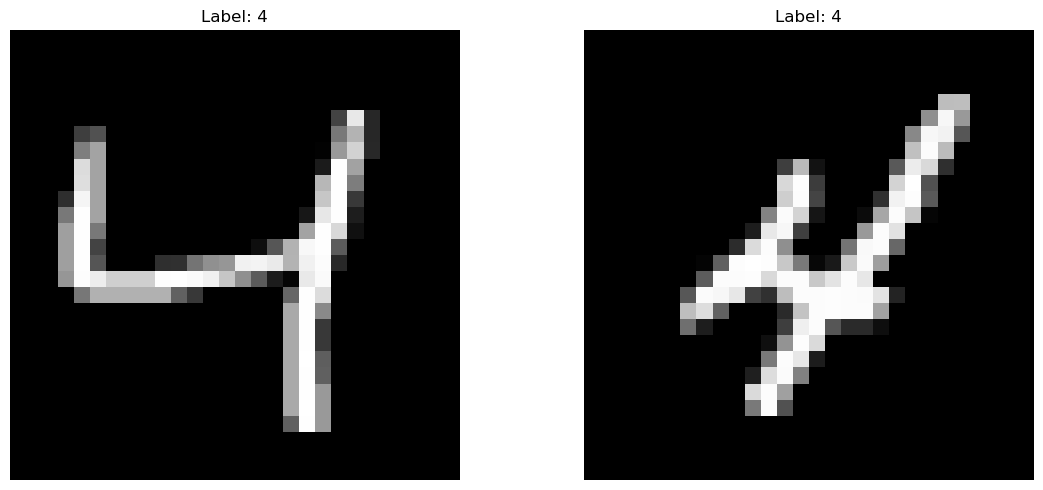

In [692]:
i1 = 2
i2 = 9

display_digits(train_dataset, [i1, i2])

In [693]:
latent1 = autoencoder.encoder(X_noisy[i1])
latent2 = autoencoder.encoder(X_noisy[i2])

distance(latent1, latent2)

12.670401573181152

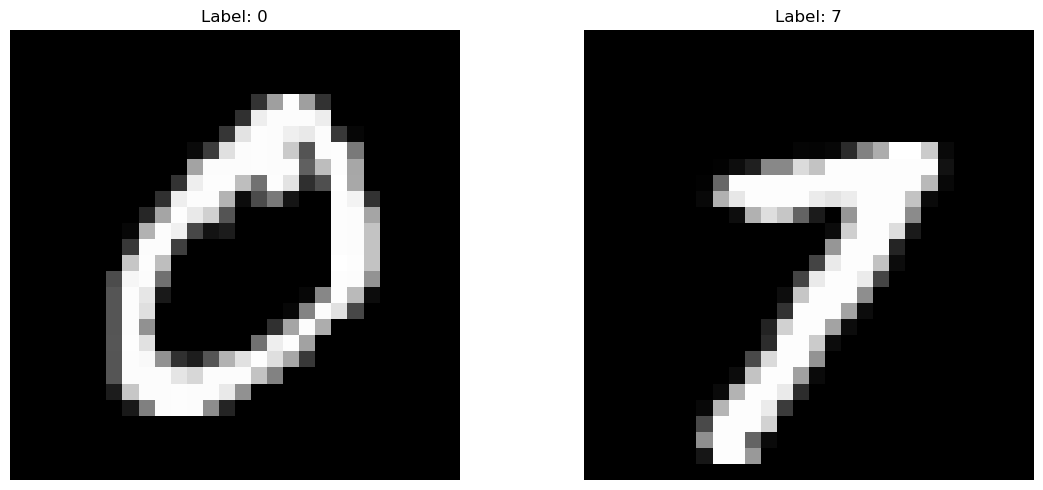

In [699]:
i1 = 1
i2 = 40000

display_digits(train_dataset, [i1, i2])

In [700]:
latent1 = autoencoder.encoder(X_noisy[i1])
latent2 = autoencoder.encoder(X_noisy[i2])

distance(latent1, latent2)

37.426116943359375

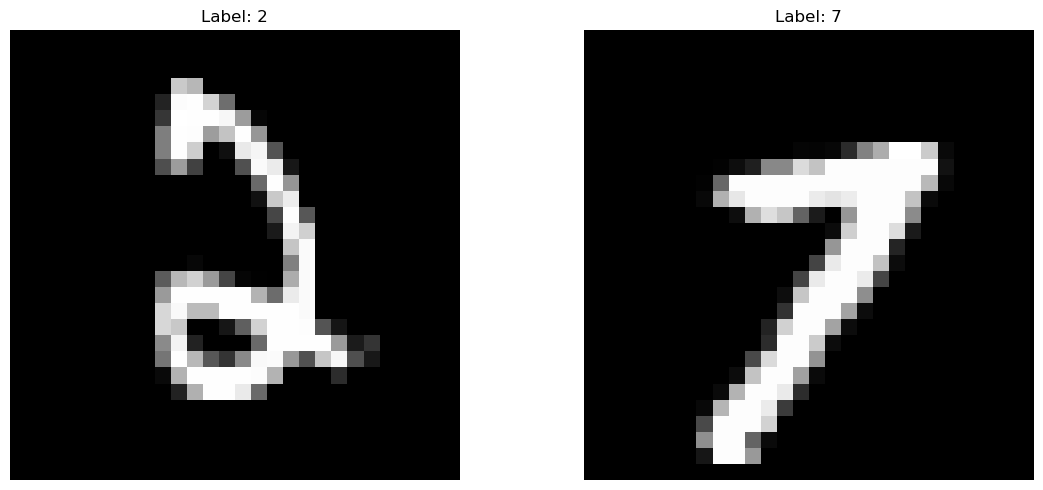

In [701]:
i1 = 49993
i2 = 40000

display_digits(train_dataset, [i1, i2])

In [702]:
latent1 = autoencoder.encoder(X_noisy[i1])
latent2 = autoencoder.encoder(X_noisy[i2])

distance(latent1, latent2)

24.89065170288086

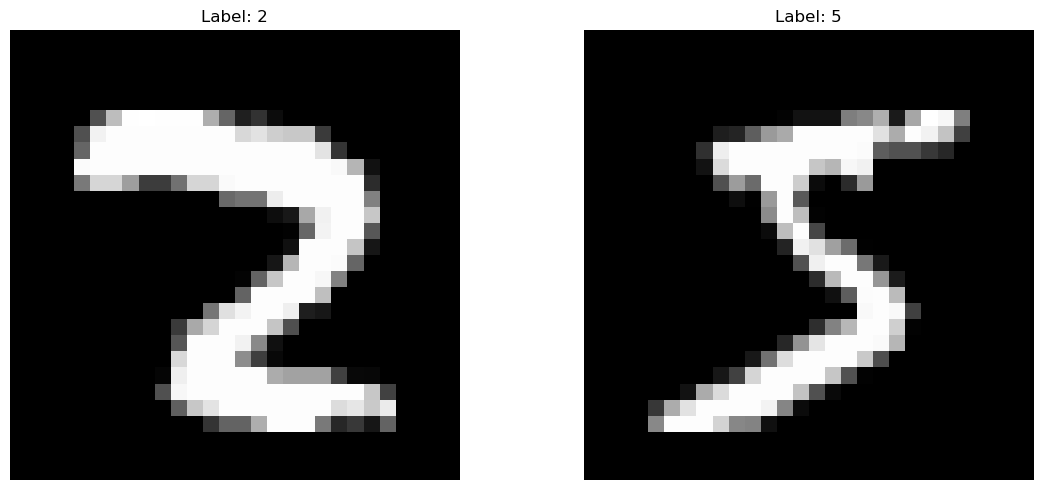

In [703]:
i1 = 28
i2 = 0

display_digits(train_dataset, [i1, i2])

In [704]:
latent1 = autoencoder.encoder(X_noisy[i1])
latent2 = autoencoder.encoder(X_noisy[i2])

distance(latent1, latent2)

16.938995361328125